In [1]:
import os
import cv2
import glob
import math
import pickle
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
INT_S2_DIR = sorted([d for d in glob.glob("_intermediate/stage2_plantdoc_pil_masked/*") if os.path.isdir(d)])[-1]

In [3]:
INT_S2_DIR

'_intermediate/stage2_plantdoc_pil_masked/2024_12_12_20_22_37'

In [4]:
names = [d for d in os.listdir(INT_S2_DIR) if os.path.isdir(os.path.join(INT_S2_DIR, d))]

In [5]:
names

['(SAM + Inception) + (AlexNet)',
 '(SAM + YOLOv8) + (InceptionV3)',
 '(SAM + YOLOv8) + (ResNet152V2)',
 '(SAM + ResNet) + (ResNet152V2)',
 '(SAM + ResNet) + (InceptionV3)',
 '(SAM + YOLOv8) + (AlexNet)',
 '(SAM + Inception) + (InceptionV3)',
 '(SAM + Inception) + (ResNet152V2)',
 '(SAM + ResNet) + (AlexNet)']

In [6]:
def select_leaves_area_k(data, k=1, offset=0):
    preds, masks = data
    ma_all = sorted(range(len(masks)), key=lambda k: masks[k]['patch'].shape[0] * masks[k]['patch'].shape[1])
    if offset == 0:
        ma_index = ma_all[-k:]
    else:
        ma_index = ma_all[-(k+offset):-offset]
    if k >= len(ma_all):
        ma_index = ma_all
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [7]:
def select_leaves_area(data, threshold=1_280):
    preds, masks = data
    indices = [i for i, mask in enumerate(masks) if mask['patch'].shape[0] * mask['patch'].shape[1] > threshold]
    preds = [data[0][i] for i in indices]
    masks = [data[1][i] for i in indices]
    return preds, masks

In [8]:
def select_leaves_area_relative(data, ratio):
    preds, masks = data
    if len(masks) == 0:
        return preds, masks
    image_area = masks[0]['segmentation'].shape[0] * masks[0]['segmentation'].shape[1]
    indices = [i for i, mask in enumerate(masks) if mask['patch'].shape[0] * mask['patch'].shape[1] > image_area * ratio]
    preds = [data[0][i] for i in indices]
    masks = [data[1][i] for i in indices]
    return preds, masks

In [9]:
def select_leaves_all(data):
    preds, masks = data
    return preds, masks

In [10]:
def select_leaves_probability_k(data, k=1):
    preds, masks = data
    for i, mask in enumerate(masks):
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
    ma_index = sorted(range(len(masks)), key=lambda k: masks[k]['leaf_probability'])[-k:]
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [11]:
def select_leaves_probability(data, threshold=.9):
    masks = []
    preds = []
    for i, mask in enumerate(data[1]):
        if 'leaf_probability' not in mask.keys():
            continue
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
        #print(mask['leaf_probability'])
        if mask['leaf_probability'] < threshold:
            continue
        masks.append(mask)
        preds.append(data[0][i])
    return preds, masks

In [12]:
def select_leaves_combined(data, k=1):
    preds, masks = data
    for i, mask in enumerate(masks):
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
    def score(k):
        return math.sqrt(math.sqrt(masks[k]['patch'].shape[0] * masks[k]['patch'].shape[1])) * masks[k]['leaf_probability']
    ma_index = sorted(range(len(masks)), key=score)[-k:]
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [13]:
def select_leaves_sharpness_k(data, k=3):
    preds, masks = data
    def score(index):
        array = cv2.cvtColor(masks[index]['patch'], cv2.COLOR_RGB2GRAY)
        gy, gx = np.gradient(array)
        mask = array > 0
        gnorm = np.sqrt((gx * mask)**2 + (gy * mask)**2)
        sharpness = np.average(gnorm)
        return sharpness
    ma_index = sorted(range(len(masks)), key=score, reverse=True)[:k]
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

(SAM + Inception) + (AlexNet)


KeyboardInterrupt: 

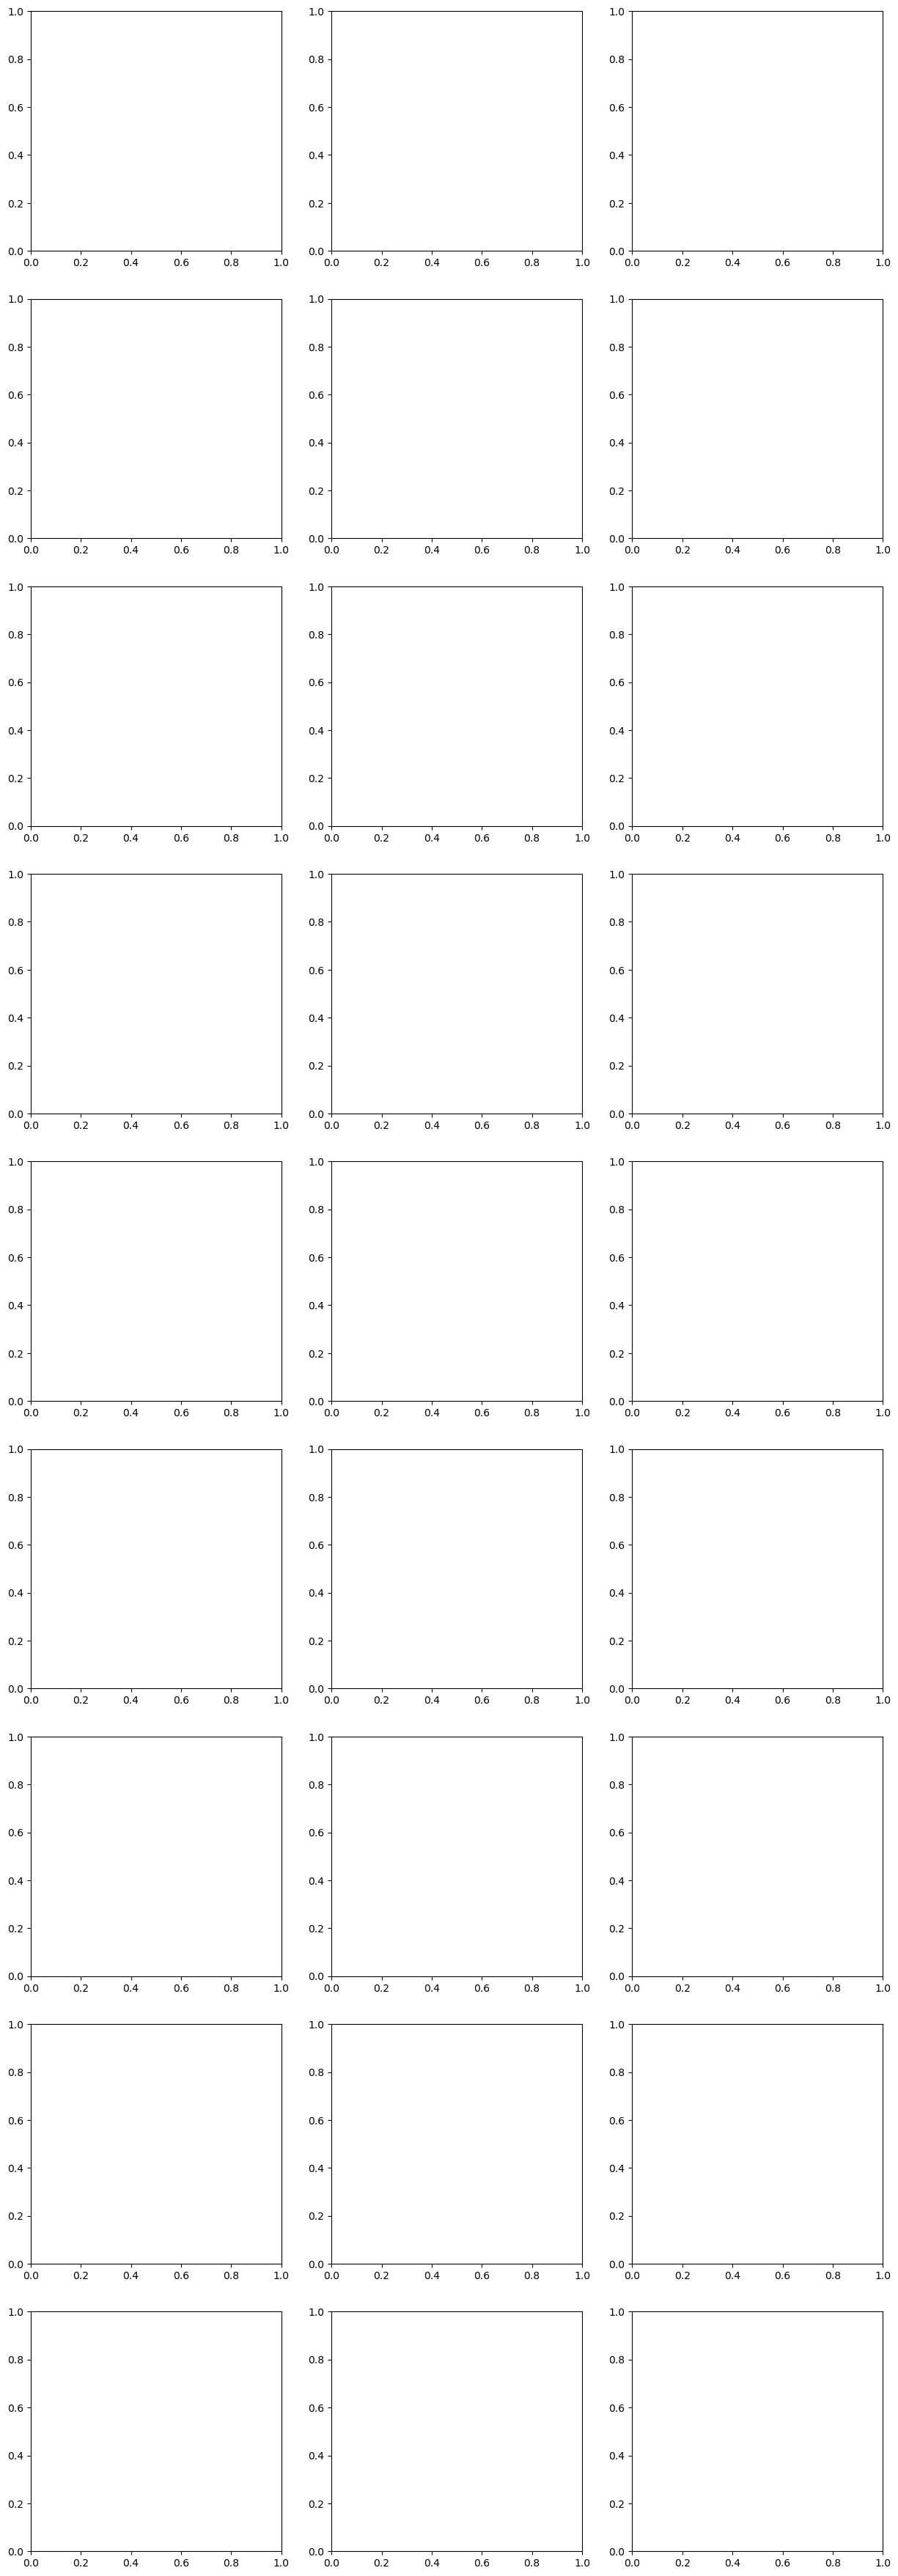

In [14]:
k = 3
fig, axes = plt.subplots(len(names), k, figsize=(15, 5 * len(names)))  # Adjust figure size
axes = np.array(axes).reshape(len(names), k)  # Ensure axes are in a 2D array if len(names) == 1

# Sample a single image_id to be used across all iterations
with open(os.path.join(INT_S2_DIR, names[0], "data.pkl"), "rb") as file:
    first_result = pickle.load(file)
image_id = random.sample(list(first_result.keys()), k=1)[0]
del first_result

for axs, name in zip(axes, names):
    print(name)
    with open(os.path.join(INT_S2_DIR, name, "data.pkl"), "rb") as file:
        result = pickle.load(file)
    print(len(result[image_id]['masks']))
    # Use the pre-selected image_id
    selected = (result[image_id]['predictions'], result[image_id]['masks'])
    selected = select_leaves_probability((result[image_id]['predictions'], result[image_id]['masks']), .95)
    selected = select_leaves_area_k(selected, k=6, offset=1)
    selected = select_leaves_sharpness_k(selected, 2)
    amount = len(selected[0])
    print(selected[0])
    print(result[image_id]['healthy'])

    # Draw subplots
    for ax, (prob, mask) in zip(axs, zip(selected[0], selected[1])):
        ax.imshow(mask['patch'])
        ax.axis('off')
        ax.set_title(f"{name}: {prob}")
    # Set title for each subfigure

plt.tight_layout()
plt.show()

In [16]:
import itertools
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pickle
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# Thread-safe structures and variables
log_lock = threading.Lock()
best_lock = threading.Lock()

# Define the ranges for hyperparameters
hyperparameter_space = {
    'DISEASED_THRESHOLD_SINGLE': [0.8, 0.85, 0.9, 0.925, 0.9375, 0.95],
    'MIN_LEAF_PROBABILITY': [0.8, 0.85, 0.9, 0.925, 0.9375, 0.95],
    'N_SELECT_AREA': [2, 3, 4],
    'OFFSET_SELECT_AREA': [0, 1],
    'N_SELECT_SHARPNESS': [2, 3, 4],
}

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(*hyperparameter_space.values()))

# DataFrame to log scores
log_df = pd.DataFrame(columns=list(hyperparameter_space.keys()) + ['name', 'auc'])

# To store the best configuration
best_config = None
best_auc = -1
best_name = None

def process_hyperparameters(name, combo, result):
    """Processes a single hyperparameter combination."""
    global best_config, best_auc, best_name

    # Assign the hyperparameters
    params = dict(zip(hyperparameter_space.keys(), combo))
    DISEASED_THRESHOLD_SINGLE = params['DISEASED_THRESHOLD_SINGLE']
    MIN_LEAF_PROBABILITY = params['MIN_LEAF_PROBABILITY']
    N_SELECT_AREA = params['N_SELECT_AREA']
    OFFSET_SELECT_AREA = params['OFFSET_SELECT_AREA']
    N_SELECT_SHARPNESS = params['N_SELECT_SHARPNESS']

    # Initialize results for the current combination
    results_conv = {'y_true': [], 'y_pred': []}
    for image_id, data in result.items():
        if len(data['masks']) == 0:
            continue
        selected = (data['predictions'], data['masks'])
        selected = select_leaves_probability(selected, MIN_LEAF_PROBABILITY)
        selected = select_leaves_area_k(selected, k=N_SELECT_AREA, offset=OFFSET_SELECT_AREA)
        selected = select_leaves_sharpness_k(selected, N_SELECT_SHARPNESS)
        for pred, mask in zip(selected[0], selected[1]):
            #print(mask['prob_diseased'])
            results_conv['y_pred'].append(int(mask['prob_diseased'] > DISEASED_THRESHOLD_SINGLE))
            results_conv['y_true'].append(1 - int(data['healthy']))

    # Skip if no results are available
    if len(results_conv['y_true']) == 0:
        return

    # Calculate AUC for the current combination
    try:
        auc = roc_auc_score(results_conv['y_true'], results_conv['y_pred'])
        
        # Thread-safe logging
        with log_lock:
            global log_df
            log_df = pd.concat([log_df, pd.DataFrame([{**params, 'name': name, 'auc': auc}])], ignore_index=True)

        # Thread-safe best configuration update
        with best_lock:
            if auc > best_auc:
                best_auc = auc
                best_config = params
                best_name = name
    except Exception as e:
        print(f"Error calculating AUC for {name} with {params}: {e}")

# Process each dataset separately to reduce memory usage
p_bar = tqdm(names, position=0, leave=None)
for name in p_bar:
    p_bar.set_description(f"Processing {name}")
    try:
        # Unpickle data for the current file
        p_bar.set_description(f"Unpickling {os.path.join(INT_S2_DIR, name, "data.pkl")}")
        with open(os.path.join(INT_S2_DIR, name, "data.pkl"), "rb") as file:
            result = pickle.load(file)

        # Use ThreadPoolExecutor to run each hyperparameter combination in a separate thread
        with ThreadPoolExecutor() as executor:
            p_bar.set_description("creating tasks")
            futures = [executor.submit(process_hyperparameters, name, combo, result) for combo in hyperparameter_combinations]
            p_bar.set_description("executing tasks")
            for future in tqdm(as_completed(futures), desc=name, total=len(futures), position=1, leave=None):
                future.result()  # Wait for completion and handle exceptions if any

    except Exception as e:
        print(f"Error processing file {name}: {e}")
        continue

# Save results to CSV
log_df.to_csv("hyperparameter_search_log.csv", index=False)

# Print the best configuration and its AUC
print(f"Best Configuration: {best_config}")
print(f"Best AUC: {best_auc}")
print(f"Best Name: {best_name}")

(SAM + Inception) + (InceptionV3): 100%|█████████▉| 647/648 [18:21<00:00,  2.19it/s]
Unpickling _intermediate/stage2_plantdoc_pil_masked/2024_12_12_20_22_37/(SAM + Inception) + (ResNet152V2)/data.pkl:  78%|███████▊  | 7/9 [2:25:35<38:52, 1166.18s/it]
executing tasks: 100%|██████████| 9/9 [3:02:40<00:00, 1217.81s/it]           


Best Configuration: {'DISEASED_THRESHOLD_SINGLE': 0.8, 'MIN_LEAF_PROBABILITY': 0.925, 'N_SELECT_AREA': 4, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}
Best AUC: 0.6970820390079951
Best Name: (SAM + YOLOv8) + (AlexNet)


In [50]:
df = pd.read_csv("hyperparameter_search_log.csv")
best_configs_df = df.loc[df.groupby('name')['auc'].idxmax()]
best_configs_df.set_index('name').drop(columns=['auc']).T.to_latex(float_format="%.3f")

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\nname & (SAM + Inception) + (AlexNet) & (SAM + Inception) + (InceptionV3) & (SAM + Inception) + (ResNet152V2) & (SAM + ResNet) + (AlexNet) & (SAM + ResNet) + (InceptionV3) & (SAM + ResNet) + (ResNet152V2) & (SAM + YOLOv8) + (AlexNet) & (SAM + YOLOv8) + (InceptionV3) & (SAM + YOLOv8) + (ResNet152V2) \\\\\n\\midrule\nDISEASED_THRESHOLD_SINGLE & 0.8000 & 0.9375 & 0.9500 & 0.8500 & 0.9500 & 0.9500 & 0.8000 & 0.9500 & 0.9500 \\\\\nMIN_LEAF_PROBABILITY & 0.9000 & 0.8000 & 0.8500 & 0.8000 & 0.8000 & 0.8000 & 0.9250 & 0.8000 & 0.8000 \\\\\nN_SELECT_AREA & 4.0000 & 3.0000 & 2.0000 & 3.0000 & 2.0000 & 2.0000 & 4.0000 & 2.0000 & 2.0000 \\\\\nOFFSET_SELECT_AREA & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \\\\\nN_SELECT_SHARPNESS & 2.0000 & 2.0000 & 2.0000 & 2.0000 & 2.0000 & 2.0000 & 2.0000 & 2.0000 & 3.0000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [47]:
results_conv = {}
DISEASED_THRESHOLD = 2.8
DISEASED_THRESHOLD_SINGLE = .95
MIN_LEAF_PROBABILITY = .95
N_SELECT_AREA = 2
OFFSET_SELECT_AREA = 0
N_SELECT_SHARPNESS = 2

df = pd.read_csv("hyperparameter_search_log.csv")
# Find the best configuration for each model

print(df.columns)

best_configs_df = df.loc[df.groupby('name')['auc'].idxmax()]

# Convert to dictionary format
best_configs = best_configs_df.set_index('name').drop(columns=['auc']).to_dict(orient='index')

p_bar = tqdm(names)
results_conv = {}

for name in p_bar:
    # Fetch the best hyperparameters for the current model
    if name in best_configs:
        config = best_configs[name]
        print("using config", config)
        DISEASED_THRESHOLD_SINGLE = config["DISEASED_THRESHOLD_SINGLE"]
        MIN_LEAF_PROBABILITY = config["MIN_LEAF_PROBABILITY"]
        N_SELECT_AREA = config["N_SELECT_AREA"]
        OFFSET_SELECT_AREA = config["OFFSET_SELECT_AREA"]
        N_SELECT_SHARPNESS = config["N_SELECT_SHARPNESS"]
    else:
        print(f"No best configuration found for {name}, using defaults.")
        continue

    p_bar.set_description("Unpickling " + name)
    with open(os.path.join(INT_S2_DIR, name, "data.pkl"), "rb") as file:
        result = pickle.load(file)
    p_bar.set_description("Converting " + name)
    results_conv[name] = {
        'y_true': [],
        'y_pred': []
    }
    for image_id, data in result.items():
        if len(data['masks']) == 0:
            continue
        selected = (data['predictions'], data['masks'])
        selected = select_leaves_probability((result[image_id]['predictions'], result[image_id]['masks']), MIN_LEAF_PROBABILITY)
        selected = select_leaves_area_k(selected, k=N_SELECT_AREA, offset=OFFSET_SELECT_AREA)
        selected = select_leaves_sharpness_k(selected, N_SELECT_SHARPNESS)
        for pred, mask in zip(selected[0], selected[1]):
            results_conv[name]['y_pred'].append(int(mask['prob_diseased'] > DISEASED_THRESHOLD_SINGLE))
            results_conv[name]['y_true'].append(1 - int(data['healthy']))
    if len(results_conv[name]['y_true']) == 0:
        print(f"{name} has no results")
        del results_conv[name]
    del result

Index(['DISEASED_THRESHOLD_SINGLE', 'MIN_LEAF_PROBABILITY', 'N_SELECT_AREA',
       'OFFSET_SELECT_AREA', 'N_SELECT_SHARPNESS', 'name', 'auc'],
      dtype='object')


Unpickling (SAM + Inception) + (AlexNet):   0%|          | 0/9 [00:00<?, ?it/s]

using config {'DISEASED_THRESHOLD_SINGLE': 0.8, 'MIN_LEAF_PROBABILITY': 0.9, 'N_SELECT_AREA': 4, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + YOLOv8) + (InceptionV3):  11%|█         | 1/9 [00:22<02:57, 22.18s/it]

using config {'DISEASED_THRESHOLD_SINGLE': 0.95, 'MIN_LEAF_PROBABILITY': 0.8, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + YOLOv8) + (ResNet152V2):  22%|██▏       | 2/9 [00:42<02:28, 21.27s/it]

using config {'DISEASED_THRESHOLD_SINGLE': 0.95, 'MIN_LEAF_PROBABILITY': 0.8, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 3}


Unpickling (SAM + YOLOv8) + (ResNet152V2):  22%|██▏       | 2/9 [00:59<03:27, 29.65s/it]


KeyboardInterrupt: 

In [18]:
for name, data in results_conv.items():
    print(name, len(data['y_pred']))

(SAM + Inception) + (AlexNet) 1018
(SAM + YOLOv8) + (InceptionV3) 1018
(SAM + YOLOv8) + (ResNet152V2) 1018
(SAM + ResNet) + (ResNet152V2) 1021
(SAM + ResNet) + (InceptionV3) 1021
(SAM + YOLOv8) + (AlexNet) 999
(SAM + Inception) + (InceptionV3) 1019
(SAM + Inception) + (ResNet152V2) 1019
(SAM + ResNet) + (AlexNet) 1021


In [19]:
import pickle
with open(os.path.join("_intermediate", "results_conv_pil_masked.pkl"), "wb+") as file:
          pickle.dump(results_conv, file)

In [20]:
import pickle
with open(os.path.join("_intermediate", "results_conv_pil_masked.pkl"), "rb") as file:
        results_conv = pickle.load(file)

In [21]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
import pandas as pd

report_df = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'accuracy', 'auc'])

for name, data in results_conv.items():
    total = len(data['y_true'])
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    report = classification_report(data['y_true'], data['y_pred'], sample_weight=sample_weight, output_dict=True)['weighted avg']
    del report['support']
    report['accuracy'] = balanced_accuracy_score(data['y_true'], data['y_pred'], sample_weight=sample_weight)
    report['auc'] = roc_auc_score(data['y_true'], data['y_pred'])
    
    report_df.loc[name] = list(report.values())

In [22]:
report_df

,precision,recall,f1-score,accuracy,auc
(SAM + Inception) + (AlexNet),0.671537,0.664255,0.660654,0.664255,0.664255
(SAM + YOLOv8) + (InceptionV3),0.671968,0.643037,0.627365,0.643037,0.643037
(SAM + YOLOv8) + (ResNet152V2),0.662127,0.624402,0.601202,0.624402,0.624402
(SAM + ResNet) + (ResNet152V2),0.641202,0.610673,0.588426,0.610673,0.610673
(SAM + ResNet) + (InceptionV3),0.659039,0.634879,0.620465,0.634879,0.634879
(SAM + YOLOv8) + (AlexNet),0.710104,0.697082,0.692314,0.697082,0.697082
(SAM + Inception) + (InceptionV3),0.684181,0.656312,0.642800,0.656312,0.656312
(SAM + Inception) + (ResNet152V2),0.649214,0.625362,0.609767,0.625362,0.625362
(SAM + ResNet) + (AlexNet),0.674345,0.663312,0.657900,0.663312,0.663312


In [40]:
report_df.to_csv("report_individual_hyperparameters.csv")

In [33]:
report_df.to_latex(float_format="%.4f")

'\\begin{tabular}{rrrrr}\n\\toprule\nprecision & recall & f1-score & accuracy & auc \\\\\n\\midrule\n0.6715 & 0.6643 & 0.6607 & 0.6643 & 0.6643 \\\\\n0.6720 & 0.6430 & 0.6274 & 0.6430 & 0.6430 \\\\\n0.6621 & 0.6244 & 0.6012 & 0.6244 & 0.6244 \\\\\n0.6412 & 0.6107 & 0.5884 & 0.6107 & 0.6107 \\\\\n0.6590 & 0.6349 & 0.6205 & 0.6349 & 0.6349 \\\\\n0.7101 & 0.6971 & 0.6923 & 0.6971 & 0.6971 \\\\\n0.6842 & 0.6563 & 0.6428 & 0.6563 & 0.6563 \\\\\n0.6492 & 0.6254 & 0.6098 & 0.6254 & 0.6254 \\\\\n0.6743 & 0.6633 & 0.6579 & 0.6633 & 0.6633 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [25]:
report_df = report_df[report_df['auc'] > .5]

9


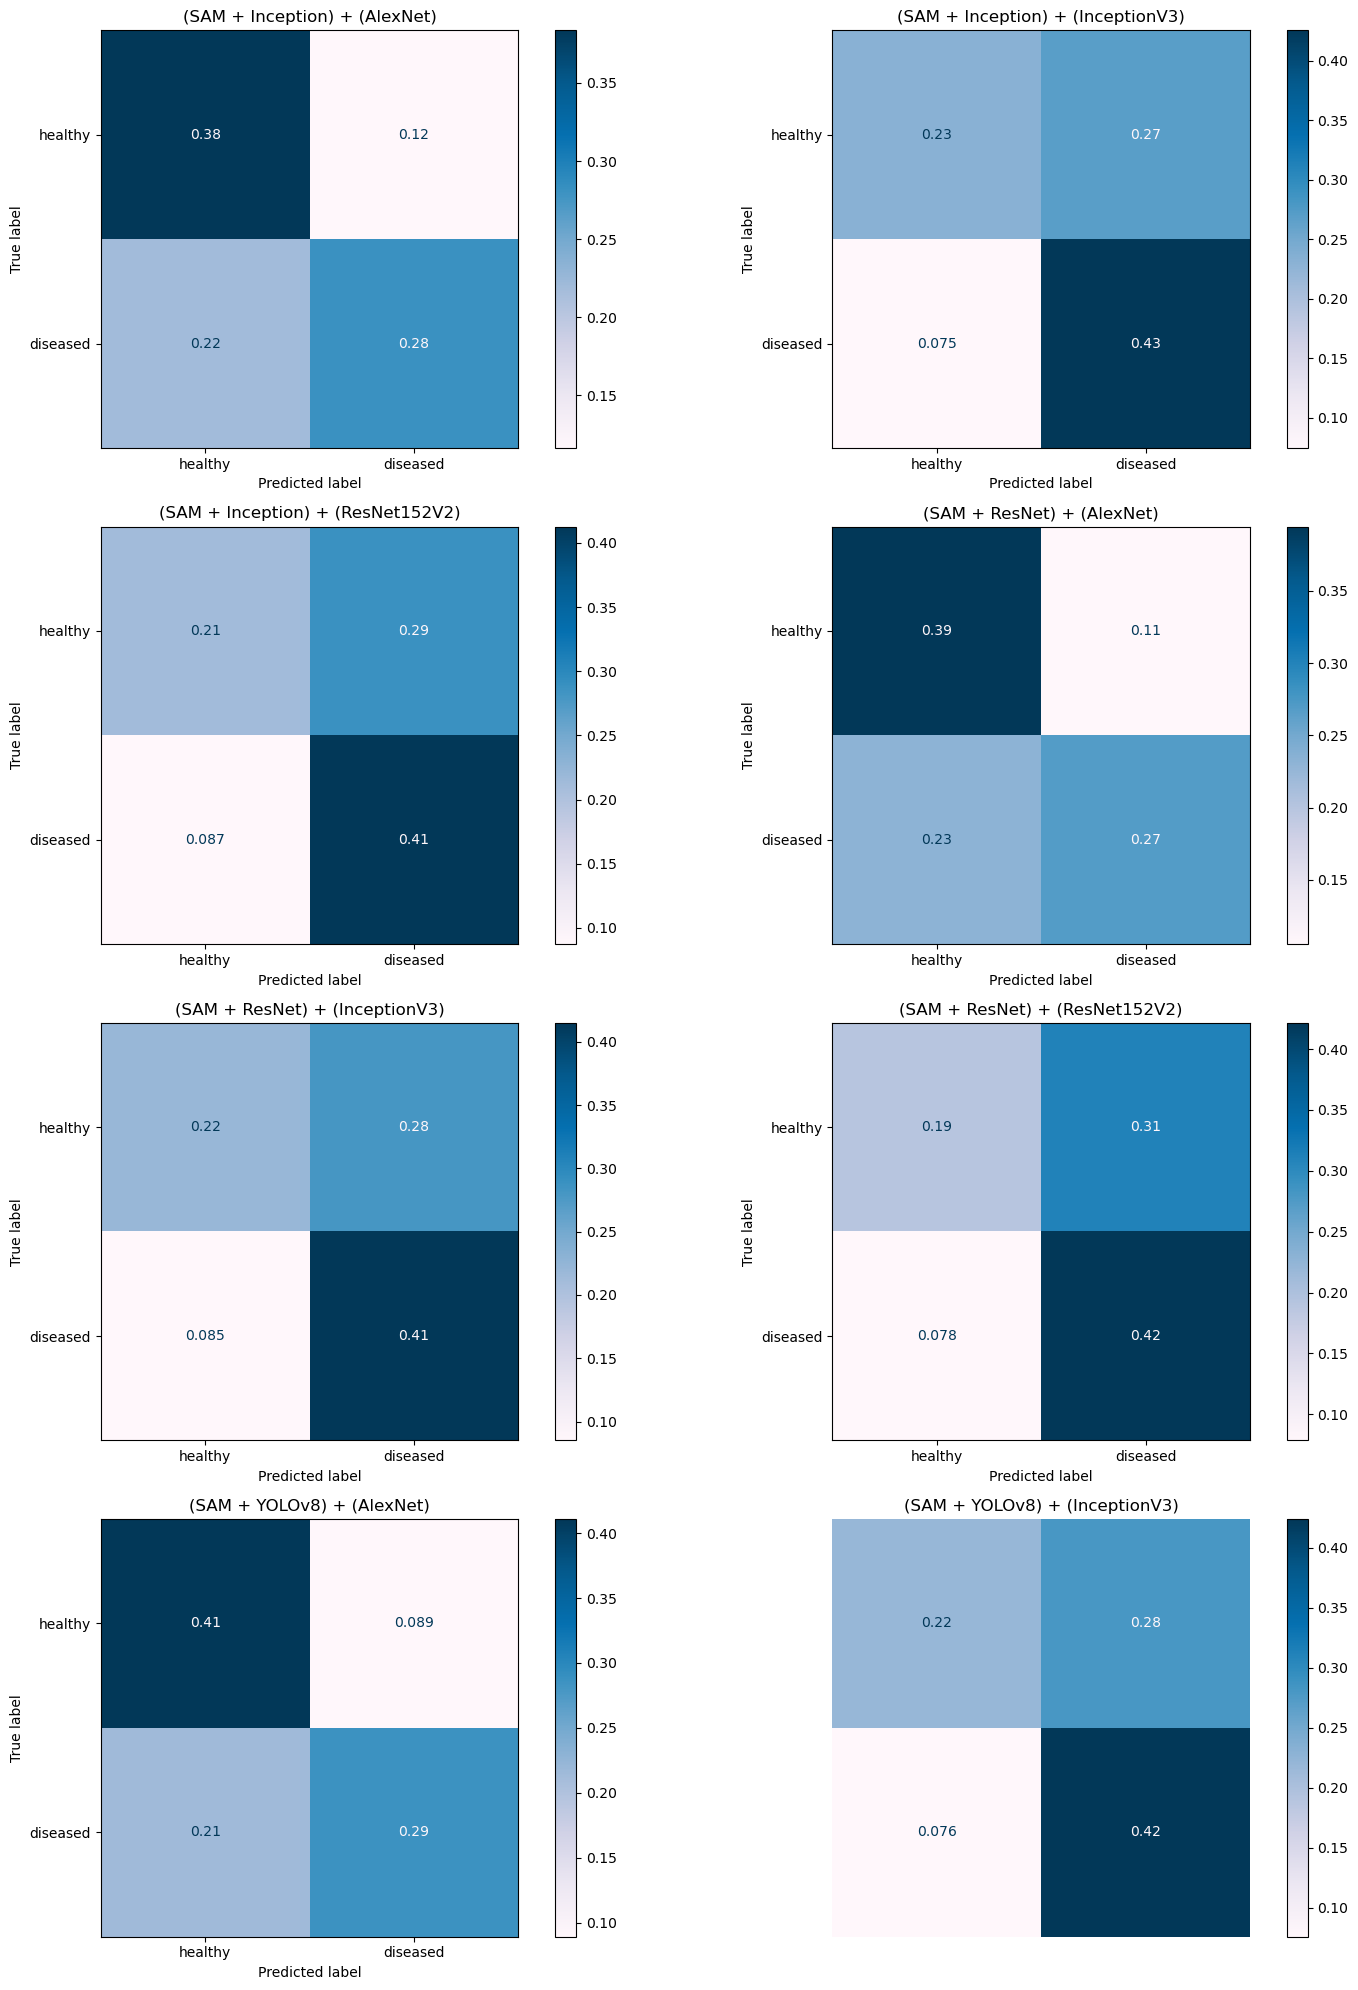

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

results_conv_sel = {key: value for key, value in results_conv.items() if key in report_df.index}
print(len(results_conv_sel))

cols = 2
fig, axes = plt.subplots((len(results_conv_sel) // cols), cols, figsize=(15, 20))
axes = axes.flatten()
axes[-1].axis('off')

for ax, (name, data) in zip(axes, sorted(results_conv_sel.items())):
    total = len(data['y_true'])
    if total == 0:
        continue
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    disp = ConfusionMatrixDisplay.from_predictions(data['y_true'], data['y_pred'],
                                                   cmap="PuBu", 
                                                   ax=ax, 
                                                   sample_weight=sample_weight, 
                                                   normalize='all',
                                                   display_labels=["healthy", 'diseased'])
    disp.ax_.set_title(name)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scaled_df = pd.DataFrame(scaler.fit_transform(report_df), columns=report_df.columns, index=report_df.index)

# Step 4: Melt the DataFrame for seaborn
scaled_df_melted = report_df.reset_index().melt(id_vars='index', 
                                                var_name='Metric', 
                                                value_name='Scaled Value')
scaled_df_melted.rename(columns={'index': 'Pipeline'}, inplace=True)

In [28]:
scaled_df_melted

,Pipeline,Metric,Scaled Value
0,(SAM + Inception) + (AlexNet),precision,0.671537
1,(SAM + YOLOv8) + (InceptionV3),precision,0.671968
2,(SAM + YOLOv8) + (ResNet152V2),precision,0.662127
3,(SAM + ResNet) + (ResNet152V2),precision,0.641202
4,(SAM + ResNet) + (InceptionV3),precision,0.659039
5,(SAM + YOLOv8) + (AlexNet),precision,0.710104
6,(SAM + Inception) + (InceptionV3),precision,0.684181
7,(SAM + Inception) + (ResNet152V2),precision,0.649214
8,(SAM + ResNet) + (AlexNet),precision,0.674345
9,(SAM + Inception) + (AlexNet),recall,0.664255


In [36]:
report_df_clipped = report_df.nlargest(5, 'auc')

In [37]:
scaled_df_melted = report_df_clipped.reset_index().melt(id_vars='index', 
                                                var_name='Metric', 
                                                value_name='Scaled Value')
scaled_df_melted.rename(columns={'index': 'Pipeline'}, inplace=True)

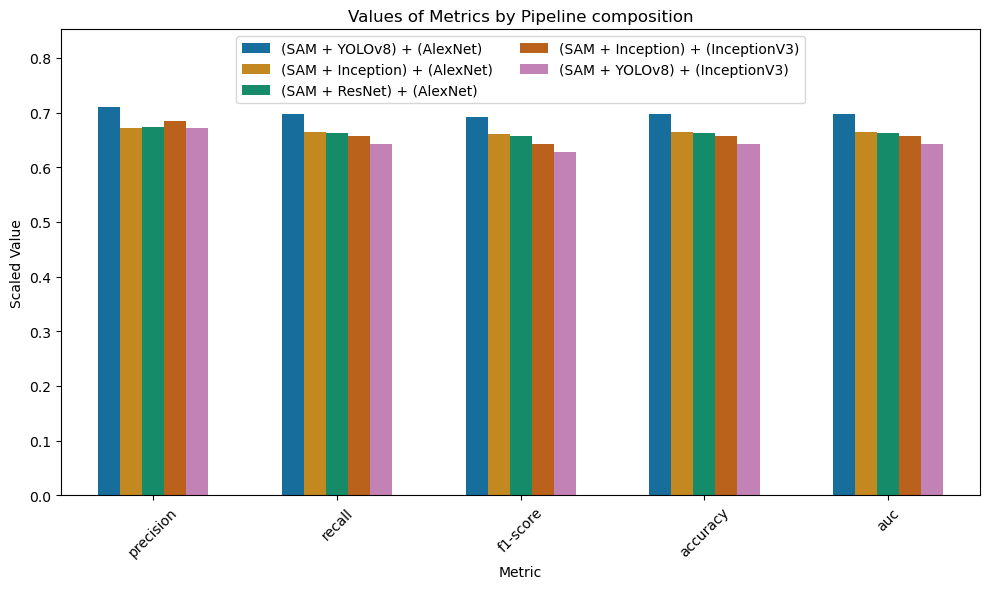

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Scaled Value', hue='Pipeline', data=scaled_df_melted, dodge=True, width=0.6, legend='brief', palette='colorblind')
ax.margins(y=.2)
ax.legend(ncol=2, loc='upper center')
plt.title('Values of Metrics by Pipeline composition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

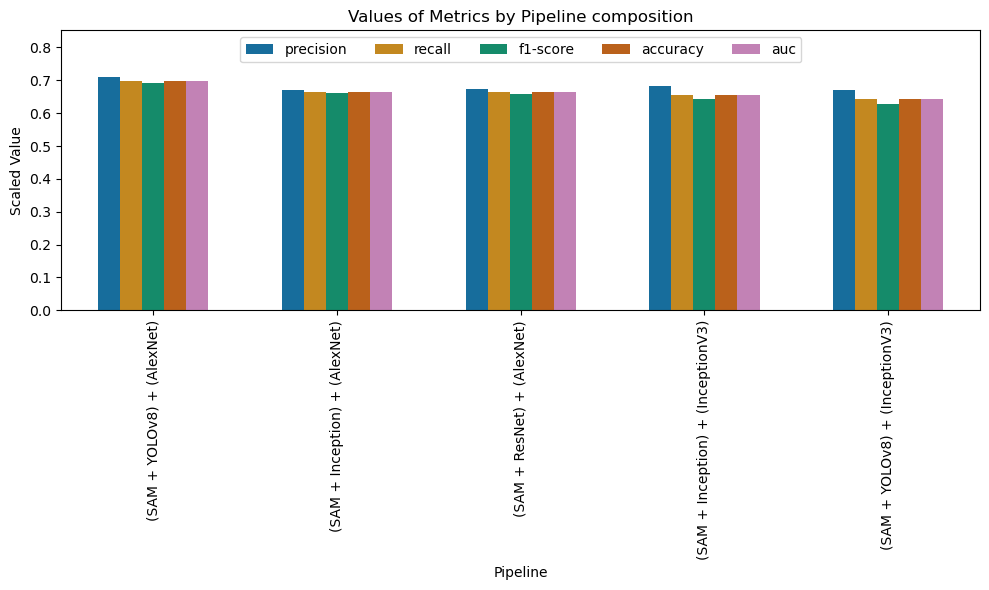

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Pipeline', y='Scaled Value', hue='Metric', data=scaled_df_melted, dodge=True, width=0.6, legend='brief', palette='colorblind')
ax.margins(y=.2)
ax.legend(ncol=5, loc='upper center')
plt.title('Values of Metrics by Pipeline composition')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()